# 书法识别竞赛

## 导入数据集

### 导入包

In [1]:
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet import autograd as ag
from mxnet import init
from mxnet.gluon.data import vision
from mxnet.gluon.data.vision import transforms
from mxnet.gluon import nn
import datetime
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


### 数据增广

In [2]:
transform_train = transforms.Compose([
#     transforms.CenterCrop(32),
#     transforms.RandomFlipTopBottom(),
#     transforms.RandomColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.0),
#     transforms.RandomLighting(0.0),
#     transforms.Cast('float32'),
#     transforms.Resize(32),
    transforms.Resize(224),
#     transforms.Resize(227),
    
    # 随机按照 scale 和 ratio 裁剪， 并放缩为 227*227 的正方形
#     transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
#     transforms.RandomResizedCrop(32, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
#     transforms.RandomFlipLeftRight(),
    # 将像素值缩小到 (0, 1) 内， 并将数据格式从 “ 高 × 宽 × 通道 ” 改为 “ 通道 × 高 × 宽”
    transforms.ToTensor()
    # 对图片的每个通道做标准化 --减去均值，除以方差
#     transforms.Normalize(mean=0.4914, std=0.2023),
    
])

transform_test = transforms.Compose([
#     transforms.Resize(227),
#     transforms.Resize(32),
    transforms.Resize(224),
    transforms.ToTensor()
#     transforms.Normalize(mean=0.4914, std=0.2023)
])

In [3]:
# vision.ImageFolderDataset??

### 读取数据集

In [4]:
data_dir = 'data/calligraphy/'

batch_size = 64

# 读取原始图像文件， flag = 0 表示图像有 1 个通道（灰度图）
train_ds = vision.ImageFolderDataset(data_dir + 'train', flag=0)
test_ds = vision.ImageFolderDataset(data_dir + 'test', flag=0)

loader = gluon.data.DataLoader
train_data = loader(train_ds.transform_first(transform_train), 
                    batch_size, shuffle=True, last_batch='keep')
test_data = loader(test_ds.transform_first(transform_test), 
                    batch_size, shuffle=False, last_batch='keep')

In [5]:
print(len(train_ds))
print(len(test_ds))

print(len(train_data))
for data, label in train_data:
    print(data.shape, label.shape)
    print(label.as_in_context(mx.gpu(0)))
    break

40000
16343
625
(64, 1, 224, 224) (64,)

[42 51 88 25 77  0 29 94 35 95 51 84 20 89 27 42 56 22 81 22 14  3 89 91 79
 75 81 91 66 66 26 55 50 31 45 78 60 99 53 13 37 41 10 96 58 57 82 95 77 85
 23 45 61 97 23 46 34 15 39 24 88 59 17 18]
<NDArray 64 @gpu(0)>


## 交叉熵损失函数

In [6]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## 设计模型 --AlexNet

In [ ]:
class AlexNet(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(AlexNet, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # conv1
            net.add(nn.Conv2D(channels=96, kernel_size=11, 
                              strides=4, padding=0))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.MaxPool2D(pool_size=3, strides=2))
            # conv2
            net.add(nn.Conv2D(channels=256, kernel_size=5, 
                              strides=1, padding=2))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.MaxPool2D(pool_size=3, strides=2))
            # conv3
            net.add(nn.Conv2D(channels=384, kernel_size=3, 
                              strides=1, padding=1))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            # conv4
            net.add(nn.Conv2D(channels=384, kernel_size=3, 
                              strides=1, padding=1))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            # conv5
            net.add(nn.Conv2D(channels=256, kernel_size=3, 
                              strides=1, padding=1))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.MaxPool2D(pool_size=3, strides=2))
            
            # FC
            net.add(nn.Flatten())
            net.add(nn.Dense(4096))
            net.add(nn.Dropout(0.5))
            net.add(nn.Dense(4096))
            net.add(nn.Dropout(0.5))
            net.add(nn.Dense(num_classes))
    
    def hybrid_forward(self, F, x):   # __init__() 里的 self
        out = x
        for i, f in enumerate(self.net):
            out = f(out)
            if self.verbose:
                print('Block %d Output: %s' % (i+1, out.shape))
        return out

In [ ]:
class Residual(nn.HybridBlock):
    def __init__(self, channels, same_shape = True, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.same_shape = same_shape
        with self.name_scope():
            strides = 1 if same_shape else 2
            self.conv1 = nn.Conv2D(channels, kernel_size = 3, 
                                   padding = 1, strides = strides)
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels, kernel_size = 3, 
                                   padding = 1)
            self.bn2 = nn.BatchNorm()
            if not same_shape:
                self.conv3 = nn.Conv2D(channels, kernel_size = 1, 
                                       strides = strides)
            
    def hybrid_forward(self, F, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if not self.same_shape:
            x = self.conv3(x)
        return F.relu(out + x)

class ResNet(nn.HybridBlock):
    def __init__(self, num_classes, verbose = False, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # modual 1
            net.add(nn.Conv2D(channels = 32, kernel_size = 3, 
                              strides = 1, padding = 1))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation = 'relu'))
            net.add(nn.Dropout(0.2))
            # modual 2
            for _ in range(3):
                net.add(Residual(channels = 32))
                net.add(nn.Dropout(0.2))
            # modual 3
            net.add(Residual(channels = 64, same_shape = False))
            net.add(nn.Dropout(0.2))
            for _ in range(2):
                net.add(Residual(channels = 64))
                net.add(nn.Dropout(0.2))
            # modual 4
            net.add(Residual(channels = 128, same_shape = False))
            net.add(nn.Dropout(0.2))
            for _ in range(2):
                net.add(Residual(channels = 128))
                net.add(nn.Dropout(0.2))
            # modual 5
            net.add(nn.AvgPool2D(pool_size = 8))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
        
    def hybrid_forward(self, F, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
            if self.verbose:
                print('Block %d output: %s' % (i+1, out.shape))
        return out

In [7]:
class residual_block(nn.HybridBlock):
    def __init__(self, channels, same_shape=True, first_residual=False, **kwargs):
        super(residual_block, self).__init__(**kwargs)
        self.same_shape = same_shape
        self.first_residual = first_residual
        strides = 1 if same_shape else 2
        with self.name_scope():
            self.bn1 = nn.BatchNorm()
            self.conv1 = nn.Conv2D(channels=channels, kernel_size=1, 
                                   strides=strides, padding=0)
            self.bn2 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels=channels, kernel_size=3, 
                                   strides=1, padding=1)
            self.bn3 = nn.BatchNorm()
            self.conv3 = nn.Conv2D(channels=4*channels, kernel_size=1, 
                                   strides=1, padding=0)
            if not same_shape:
                self.conv4 = nn.Conv2D(channels=4*channels, kernel_size=1, 
                                       strides=strides, padding=0)
            elif first_residual:
                self.conv4 = nn.Conv2D(channels=4*channels, kernel_size=1, 
                                       strides=strides, padding=0)
    
    def hybrid_forward(self, F, x):
        x = F.relu(self.bn1(x))
        out = self.conv1(x)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        if not self.same_shape or self.first_residual:
            x = self.conv4(x)
        return out + x
    
class ResNet50(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ResNet50, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # stage 1
            net.add(nn.Conv2D(channels=64, kernel_size=7, 
                              strides=2, padding=3))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
            # stage 2
            net.add(residual_block(64, first_residual=True))
            for _ in range(2):
                net.add(residual_block(64))
            # stage 3
            net.add(residual_block(128, same_shape=False))
            for _ in range(3):
                net.add(residual_block(128))
            # stage 4
            net.add(residual_block(256, same_shape=False))
            for _ in range(5):
                net.add(residual_block(256))
            # stage 5
            net.add(residual_block(512, same_shape=False))
            for _ in range(2):
                net.add(residual_block(512))
            # stage 6
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.AvgPool2D(pool_size=7))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
            
    def hybrid_forward(self, F, x):
        out = x
        for i, f in enumerate(self.net):
            out = f(out)
            if self.verbose:
                print('Block %d, Output: %s' % (i+1, out.shape))
        return out

In [8]:
def get_net(ctx, num_classes=100):
#     net = AlexNet(num_classes)
#     net = ResNet(num_classes)
    net = ResNet50(num_classes)
    net.initialize(ctx=ctx, init=init.Xavier())
    return net

In [9]:
def train(train_data, valid_data, net, ctx, num_epoches, 
          learning_rate=0.01, lr_decay=0.1, lr_period=50, 
          momentum = 0.9, weight_decay=0, cost_period = 10, 
          print_cost=False):
    costs = []
#     trainer = gluon.Trainer(net.collect_params(), 'sgd', 
#                             {'learning_rate': learning_rate, 
#                              'momentum': momentum, 
#                              'wd': weight_decay})
    trainer = gluon.Trainer(net.collect_params(), 'adam', 
                            {'learning_rate': learning_rate})
    pre_time = datetime.datetime.now()
#     moving_loss = 0
#     niter = 0
    for epoch in range(num_epoches):
        train_loss = 0
        train_acc = 0
        if (epoch+1) % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for data, label in train_data:
            data = data.as_in_context(ctx)
#             label = label.as_in_context(ctx)
            label = label.astype('float32').as_in_context(ctx)
            with ag.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
#             print(output.argmax(axis=1).astype(np.int64), label)
            train_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
#             train_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
#             niter += 1
#             cur_loss = nd.mean(loss).asscalar()
#             moving_loss = 0.9 * moving_loss + 0.1 * cur_loss
#             corr_loss = moving_loss / pow(0.9, niter)
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - pre_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_acc = 0
            for data, label in valid_data:
                data = data.as_in_context(ctx)
#                 label = label.as_in_context(ctx)
                label = label.astype('float32').as_in_context(ctx)
                output = net(data)
#                 valid_acc += nd.mean(output.argmax(axis=1).astype(np.int64) == label).asscalar()
                valid_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, valid_acc %f, " % (epoch+1, 
                                                                                   train_loss/len(train_data), 
                                                                                   train_acc/len(train_data), 
                                                                                   valid_acc/len(valid_data))
        else:
            epoch_str = "Epoch %d, train_loss: %f, train_acc: %f, " % (epoch+1, 
                                                                     train_loss/len(train_data), 
                                                                     train_acc/len(train_data))
        if print_cost and (epoch+1) % cost_period == 0:
#             costs.append(corr_loss)
            costs.append(train_loss/len(train_data))
        print(epoch_str + time_str + ', lr: %f' % trainer.learning_rate)
        pre_time = cur_time
    if print_cost:
        x_axis = np.linspace(0, num_epoches, len(costs), endpoint = True)
        plt.semilogy(x_axis, costs)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

In [10]:
valid_data = None
ctx = mx.gpu(0)
num_epoches = 200
learning_rate = 0.01
lr_decay = 0.1
lr_period = 50
momentum = 0.9
weight_decay = 5e-4
cost_period = 10

Epoch 1, train_loss: 4.666875, train_acc: 0.013600, Time 00:03:44, lr: 0.010000
Epoch 2, train_loss: 4.209906, train_acc: 0.055575, Time 00:03:43, lr: 0.010000
Epoch 3, train_loss: 2.967842, train_acc: 0.271750, Time 00:03:41, lr: 0.010000
Epoch 4, train_loss: 1.842795, train_acc: 0.534200, Time 00:03:41, lr: 0.010000
Epoch 5, train_loss: 1.267472, train_acc: 0.678775, Time 00:03:41, lr: 0.010000
Epoch 6, train_loss: 0.982198, train_acc: 0.748200, Time 00:03:41, lr: 0.010000
Epoch 7, train_loss: 0.787672, train_acc: 0.799150, Time 00:03:44, lr: 0.010000
Epoch 8, train_loss: 0.646470, train_acc: 0.831275, Time 00:03:42, lr: 0.010000
Epoch 9, train_loss: 0.540609, train_acc: 0.858325, Time 00:03:42, lr: 0.010000
Epoch 10, train_loss: 0.469920, train_acc: 0.876700, Time 00:03:41, lr: 0.010000
Epoch 11, train_loss: 0.399983, train_acc: 0.890975, Time 00:03:41, lr: 0.010000
Epoch 12, train_loss: 0.333821, train_acc: 0.906775, Time 00:03:41, lr: 0.010000
Epoch 13, train_loss: 0.281528, train

Epoch 103, train_loss: 0.000287, train_acc: 0.999850, Time 00:03:41, lr: 0.000100
Epoch 104, train_loss: 0.000283, train_acc: 0.999850, Time 00:03:41, lr: 0.000100
Epoch 105, train_loss: 0.000290, train_acc: 0.999875, Time 00:03:41, lr: 0.000100
Epoch 106, train_loss: 0.000286, train_acc: 0.999850, Time 00:03:41, lr: 0.000100
Epoch 107, train_loss: 0.000280, train_acc: 0.999875, Time 00:03:41, lr: 0.000100
Epoch 108, train_loss: 0.000282, train_acc: 0.999850, Time 00:03:41, lr: 0.000100
Epoch 109, train_loss: 0.000284, train_acc: 0.999875, Time 00:03:41, lr: 0.000100
Epoch 110, train_loss: 0.000285, train_acc: 0.999875, Time 00:03:41, lr: 0.000100
Epoch 111, train_loss: 0.000284, train_acc: 0.999875, Time 00:03:41, lr: 0.000100
Epoch 112, train_loss: 0.000282, train_acc: 0.999875, Time 00:03:41, lr: 0.000100
Epoch 113, train_loss: 0.000288, train_acc: 0.999850, Time 00:03:41, lr: 0.000100
Epoch 114, train_loss: 0.000287, train_acc: 0.999850, Time 00:03:41, lr: 0.000100
Epoch 115, train

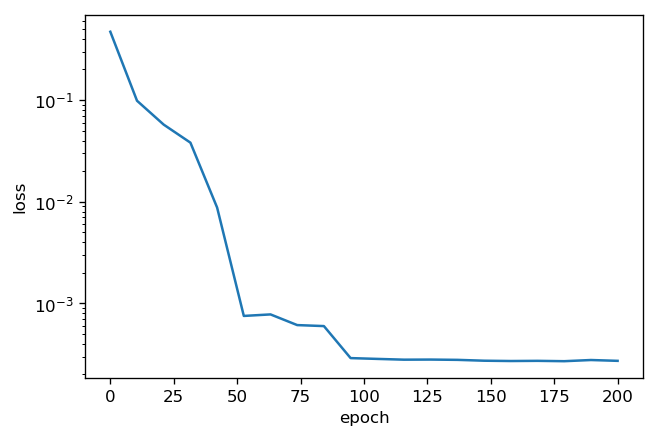

In [11]:
net = get_net(ctx, num_classes=100)
net.hybridize()
train(train_data, valid_data, net, ctx, num_epoches, 
      learning_rate, lr_decay, lr_period, 
      momentum, weight_decay, cost_period, 
      print_cost=True)

In [12]:
preds = []
for data, label in test_data:
    data = data.as_in_context(ctx)
    output = net(data)
    preds.extend(output.argsort(axis = 1)[:, -5:].astype(int).asnumpy())

filenames = []
top_5_labels = []
for m in range(len(preds)):
    str1 = test_ds.items[m][0][30:]
    filenames.append(str1)
    str2 = ""
    for index in reversed(preds[m]):
        label = train_ds.synsets[index]
        str2 += label
    top_5_labels.append(str2)

df = pd.DataFrame({'filename': filenames, 'label': top_5_labels})
df.to_csv('submission.csv', encoding='utf-8', index=False)

In [ ]:
# pd.DataFrame??
# pd.DataFrame.to_csv??

In [ ]:
# filenames = []
# top_5_labels = []
# for m in range(len(preds)):
#     str1 = test_ds.items[m][0][30:]
#     filenames.append(str1)
#     str2 = ""
#     for index in reversed(preds[m]):
#         label = train_ds.synsets[index]
#         str2 += label
#     top_5_labels.append(str2)

# print(filenames[500],top_5_labels[500])

In [ ]:
# print(train_ds.items[399])
# print(train_ds.items[400][0])
# print(train_ds.items[400][0][25:])
# print(test_ds.items[0])
# print(test_ds.items[0][0])
# print(test_ds.items[0][0][30:])

In [ ]:
# pred = []
# # a =nd.array([[2, 5, 1, 3, 4, 8, 10]])
# a =nd.array([[2, 5, 1, 3, 4, 8, 10], [3, 7, 5, 8, 10, 12, 51]])
# print(a)
# b = a.argsort(axis = 1)[:, -5:].astype(int).asnumpy()
# print(b)
# pred.extend(b)
# print(len(pred))
# print(type(np.array(pred[1])))
# print(np.array(pred))
# print(output.shape)
# print(len(preds[100]))
# for i in reversed(preds[1]):
#     print(i)

In [ ]:
#  # label for directory in disk
# def label_of_directory(directory):
#     """
#     sorted for label indices
#     return a dict for {'classes', 'range(len(classes))'}
#     """
#     classes = []
#     for subdir in sorted(os.listdir(directory)):
#         if os.path.isdir(os.path.join(directory, subdir)):
#             classes.append(subdir)

#     num_classes = len(classes)
#     class_indices = dict(zip(classes, range(len(classes))))
#     return class_indices

# # get key from value in dict
# def get_key_from_value(dict, index):
#     for keys, values in dict.items():
#         if values == index:
#             return keys

# # geneartor list of image list in test
# def generator_list_of_imagepath(path):
#     image_list = []
#     for image in os.listdir(path):
#         if not image == '.DS_Store':
#             image_list.append(path + image)
#     return image_list

# # read image and resize to gray
# def load_image(image):
#     img = Image.open(image)
#     img = img.resize((128, 128))
#     img = np.array(img)
#     img = img / 255
#     img = img.reshape((1,) + img.shape + (1,))  # reshape img to size(1, 128, 128, 1)
#     return img

# # get label of model predict test image top_1 preidct
# def get_label_predict_top1(image, model):
#     """
#     image = load_image(image), input image is a ndarray
#     retturn best of label
#     """
#     predict_proprely = model.predict(image)
#     predict_label = np.argmax(predict_proprely, axis=1)
#     return predict_label

# # get label of model predict test image top_k predict
# def get_label_predict_top_k(image, model, top_k):
#     """
#     image = load_image(image), input image is a ndarray
#     return top-5 of label
#     """
#     # array 2 list
#     predict_proprely = model.predict(image)
#     predict_list = list(predict_proprely[0])
#     min_label = min(predict_list)
#     label_k = []
#     for i in range(top_k):
#         label = np.argmax(predict_list)
#         predict_list.remove(predict_list[label])
#         predict_list.insert(label, min_label)
#         label_k.append(label)
#     return label_k

# # test image predict best label from model
# def test_image_predict_top1(model, test_image_path, directory):

#     model.load_weights(WEIGHTS_PATH)
#     image_list = generator_list_of_imagepath(test_image_path)

#     predict_label = []
#     class_indecs = label_of_directory(directory)
#     for image in image_list:
#         img = load_image(image)
#         label_index = get_label_predict_top1(img, model)
#         label = get_key_from_value(class_indecs, label_index)
#         predict_label.append(label)

#     return predict_label

# # test image predict top-5 label from model
# def test_image_predict_top_k(modle, test_image_path, directory, top_k):

#     model.load_weights(WEIGHTS_PATH)
#     image_list = generator_list_of_imagepath(test_image_path)

#     predict_label = []
#     class_indecs = label_of_directory(directory)
#     for image in image_list:
#         img = load_image(image)
#         # return a list of label max->min
#         label_index = get_label_predict_top_k(img, model, 5)
#         label_value_dict = []
#         for label in label_index:
#             label_value = get_key_from_value(class_indecs, label)
#             label_value_dict.append(str(label_value))

#         predict_label.append(label_value_dict)

#     return predict_label

# # translate list to str in label
# def tran_list2str(predict_list_label):
#     new_label = []
#     for row in range(len(predict_list_label)):
#         str = ""
#         for label in predict_list_label[row]:
#             str += label
#         new_label.append(str)
#     return new_label

# # save filename , lable as csv
# def save_csv(test_image_path, predict_label):
#     image_list = generator_list_of_imagepath(test_image_path)
#     save_arr = np.empty((10000, 2), dtype=np.str)
#     save_arr = pd.DataFrame(save_arr, columns=['filename', 'label'])
#     predict_label = tran_list2str(predict_label)
#     for i in range(len(image_list)):
#         filename = image_list[i].split('/')[-1]
#         save_arr.values[i, 0] = filename
#         save_arr.values[i, 1] = predict_label[i]
#     save_arr.to_csv('submit_test.csv', decimal=',', encoding='utf-8', index=False, index_label=False)
# print('submit_test.csv have been write, locate is :', os.getcwd())